In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vector
import copy
import math
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

This notebook has dimensionlesss sigma

Units in Distance are: 1Unit = 0.335*10^-9 meters
Units in time are: 1 unit = 0.35*10^-9 seconds

In [4]:
class Simulation:
    def __init__(self,length,initial_particle_x,initial_particle_y,initial_particle_z):
        #Maximum/minimum spatial coordinates of contained atoms
        self.max_displacement = length/2 #(m)
        self.min_displacement = -length/2 #(m)
        #Some useful physical constants
        self.sigma = 0.3345*10**-9 #(m)
        self.boltzmann_constant = 1.38*10**-23 #(J/K)
        self.argon_mass = 6.63*10**-26 #(kg)

        self.instantaneous_del_momentum_x_positive = 0 #(kgm/s)
        #Variable storing the total change in momentum along the +ve x face of the simulation container
        self.total_del_momentum_x_positive = 0 #(kgm/s)
        #Array of time value for each time
        self.times = []
        #Array of gas temperatuere for each time 
        self.temperatures = []
        #Array of average simulation pressure for each time
        self.pressures = []

        #Instantiate the instantaneous kinematic vector arrays and apply intiial conditions
        self.current_x = copy.copy(initial_particle_x)
        self.current_y = copy.copy(initial_particle_y)
        self.current_z = copy.copy(initial_particle_z)

        self.current_v_x = np.zeros(len(initial_particle_x))
        self.current_v_y = np.zeros(len(initial_particle_x))
        self.current_v_z = np.zeros(len(initial_particle_x))

        self.current_a_x = np.zeros(len(initial_particle_x))
        self.current_a_y = np.zeros(len(initial_particle_x))
        self.current_a_z = np.zeros(len(initial_particle_x))
        #Instantiate the record holding kinematic vector arrays and store the initial conditions 
        self.particles_x = [copy.copy(initial_particle_x)]
        self.particles_y = [copy.copy(initial_particle_y)]
        self.particles_z = [copy.copy(initial_particle_z)]

        self.particles_v_x = [np.zeros(len(initial_particle_x))]
        self.particles_v_y = [np.zeros(len(initial_particle_x))]
        self.particles_v_z = [np.zeros(len(initial_particle_x))]

        self.particles_a_x = [np.zeros(len(initial_particle_x))]
        self.particles_a_y = [np.zeros(len(initial_particle_x))]
        self.particles_a_z = [np.zeros(len(initial_particle_x))]


    
    def update_acceleration(self):
        #Argon parameters
        sigma = 0.3345*10**-9 #m
        epsilon = 1.735*10**-21
        argon_mass = 6.63*10**-26 #kg
        #For each particle in the simulation:
        for i in range(0,len(self.current_x)):
            #Instantiate the force vector acting upon particle_i exerted by all other simulation particles, j
            vec_force_i  = np.asarray([0,0,0])
            #For each other particle in the simulation:
            for j in range(0,len(self.current_x)):
                if (i == j):
                    continue
                #Instantiate numpy position vectors to make calculation simpler
                r_i = np.asarray([self.current_x[i],self.current_y[i],self.current_z[i]])
                r_j = np.asarray([self.current_x[j],self.current_y[j],self.current_z[j]])
                #Calculate the displacment vector of the two particles 
                r_ji = r_i - r_j
                r_ji_mag = math.sqrt(abs(np.dot(r_ji,r_ji)))
                #To simulate brownian motion, particles cannot collide directly.
                #This means we stop calculating interactions when particles within 1 sigma radius
                if (r_ji_mag < 1*sigma):
                    continue
                r_ji_direction = r_ji/r_ji_mag
                
                try:
                    #Force equation is derived from the radial distance derivative of Lennard-Jones potential governing inter-molecular forces
                    if (r_ji_mag**13 != 0):
                        mag_force = (24*epsilon*(self.sigma**6)*(r_ji_mag**6-2*self.sigma**6))/(r_ji_mag**13)
                    else:
                        mag_force = 0
                    
                    vec_force_ji = mag_force*r_ji_direction
                    vec_force_i = vec_force_i + vec_force_ji
                except:
                    continue

            #Finally we have spatial acceleration vector
            vec_acc_i = vec_force_i/argon_mass
            if (r_ji_mag**10 != 0):
                #Copy.copy allows tp store by value as opposed to by reference, this allows code to book keep the history of the simulation
                self.current_a_x[i] = copy.copy(vec_acc_i[0])
                self.current_a_y[i] = copy.copy(vec_acc_i[1])
                self.current_a_z[i] = copy.copy(vec_acc_i[2])
            else:
                self.current_a_x[i] = 0
                self.current_a_y[i] = 0
                self.current_a_z[i] = 0
            

    def update_velocity(self,dt=0.00001):
        #For each particle in the simulation
        for i in range(0,len(self.current_x)):
            #Construct numpy vecotrs to simplify calculations 
            temp_acceleration = np.asarray([self.current_a_x[i],self.current_a_y[i],self.current_a_z[i]])
            temp_velocity = np.asarray([self.current_v_x[i],self.current_v_y[i],self.current_v_z[i]])
            #calculate new velocity according to vernier-scarlet integration
            temp_new_velocity = temp_velocity+(dt/2)*temp_acceleration
            #Assign current parameters to a deep copy to prevent bugs
            self.current_v_x[i] = copy.copy(temp_new_velocity[0])
            self.current_v_y[i] = copy.copy(temp_new_velocity[1])
            self.current_v_z[i] = copy.copy(temp_new_velocity[2])

            
    def update_position(self,dt=0.00001):
        #Reset momentum counter
        self.instantaneous_del_momentum_x_positive = 0
        #For each particle in the sim:
        for i in range(0,len(self.current_x)):
            #Construct np arrays to simplify calculations
            position = np.asarray([self.current_x[i],self.current_y[i],self.current_z[i]])
            velocity = np.asarray([self.current_v_x[i],self.current_v_y[i],self.current_v_z[i]])
            position = position + (dt)*velocity
            #In +ve x direction:
            if (position[0] > self.max_displacement): #if a particle has passed 'tried' to pass the boundary 
                #Place the particle at the boundary
                position[0] = self.max_displacement
                #Increment the total del_momentum in x for future momentum calculation
                self.instantaneous_del_momentum_x_positive += self.argon_mass*math.sqrt(abs(np.dot(velocity,velocity)))
                self.total_del_momentum_x_positive += self.argon_mass*math.sqrt(abs(np.dot(velocity,velocity)))
                #Reverse its momentum in relevant direction to simulate an elastic collision
                velocity[0] = -1*velocity[0]
            #in -ve x direction:
            if(position[0] < self.min_displacement):
                #Place the particle at the boundary
                position[0] = self.min_displacement
                #We will not consider del momentum for any other directions, since principle of pressure symmetry should
                #allow us to calculate total pressure from total del momentum using one sign of one axis.
                velocity[0] = -1*velocity[0]
            #On y axis:
            if (position[1] > self.max_displacement): 
                position[1] = self.max_displacement
                velocity[1] = -1*velocity[1]
            if(position[1] < self.min_displacement):
                position[1] = self.min_displacement
                velocity[1] = -1*velocity[1]
            #On z axis:
            if (position[2] > self.max_displacement): 
                position[2] = self.max_displacement
                velocity[2] = -1*velocity[2]
            if(position[2] < self.min_displacement):
                position[2] = self.min_displacement
                velocity[2] = -1*velocity[2]

            self.current_x[i] = copy.copy(position[0])
            self.current_y[i] = copy.copy(position[1])
            self.current_z[i] = copy.copy(position[2])
            self.current_v_x[i] = copy.copy(velocity[0])
            self.current_v_y[i] = copy.copy(velocity[1])
            self.current_v_z[i] = copy.copy(velocity[2])
    

    def capture_state(self):
        #Append Position
        self.particles_x.append(copy.copy(self.current_x))
        self.particles_y.append(copy.copy(self.current_y))
        self.particles_z.append(copy.copy(self.current_z))
        #Append Velocity
        self.particles_v_x.append(copy.copy(self.current_v_x))
        self.particles_v_y.append(copy.copy(self.current_v_y))
        self.particles_v_z.append(copy.copy(self.current_v_z))
        #Append acceleration
        self.particles_a_x.append(copy.copy(self.current_a_x))
        self.particles_a_y.append(copy.copy(self.current_a_y))
        self.particles_a_z.append(copy.copy(self.current_a_z))
        

    def calculate_average_pressure(self,delt):
        #Define area as the square of simulation side length
        face_area = (self.max_displacement*2)**2
        #Calculate total time as time step * number of steps
        total_time = delt*len(self.particles_x)
        #Calculate average pressure per time
        p_x_average = (1/(face_area*total_time))*self.total_del_momentum_x_positive
        #Assume pressure symmetry to calculate total pressure
        presure_average = 3*p_x_average
        return presure_average

    def calculate_temperature(self):
        # Temperature related to total KE of a gas
        KE = 0
        N_particles = len(self.current_x)
        #For each particle
        for i in range(0,N_particles):
            #Construct np array for velocity to shorten calculation
            velocity_arr = np.asarray([self.current_v_x[i],self.current_v_y[i],self.current_v_z[i]])
            current_vel_mag_sq = abs(np.dot(velocity_arr,velocity_arr))
            #KE = Sum over n of 1/2*m_n*(v_n)^2
            KE+= 0.5*self.argon_mass*current_vel_mag_sq
        #Apply temperature equation
        temperature = KE*(0.666)/(N_particles*self.boltzmann_constant)
        #Append temperature to array of temperature records
        self.temperatures.append(copy.copy(temperature))
        return temperature

    def calculate_average_temperature(self):
        temperatures = np.asanyarray(self.temperatures)
        average_temp = np.mean(temperatures)
        return average_temp
    

    def main(self,delt = 0.00001,nSteps=100,maxTime=0):
        #Initialize time
        time=0
        #Append initial time
        self.times = [0]
        if (maxTime == 0):
            maxTime = nSteps*delt
        while (time <= maxTime):
            #Increment time
            time = time+delt
            #Calculate & update particle accelerations
            self.update_acceleration()
            #Calculate and update particle velocities
            self.update_velocity(dt = delt)
            #Calculate and update particle positions
            self.update_position(dt = delt)
            #Store current simulation state
            self.capture_state()
            #Calculate and store gas temperature
            self.calculate_temperature()
            self.times.append(time+delt)

        




Task 1 Testing

In [5]:
sigma = 0.3345*10**-9 #m
#Defining an initial configuration of two test particles. 
#One at origin, one displaced along x axis by 7 sigma (m)
initial_x = [0.0,7*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]
#Construct simulation with initial state as parameters
sim1 = Simulation(length= 100*sigma,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
sim1.main(delt=0.3*sigma)

#Extract data for use in plot
xCoords = sim1.particles_x
xCoords = np.transpose(xCoords)
xVelCoords = sim1.particles_v_x
xAccCoords = sim1.particles_a_x
xVelCoords = np.transpose(xVelCoords)
times = sim1.times


(102,)

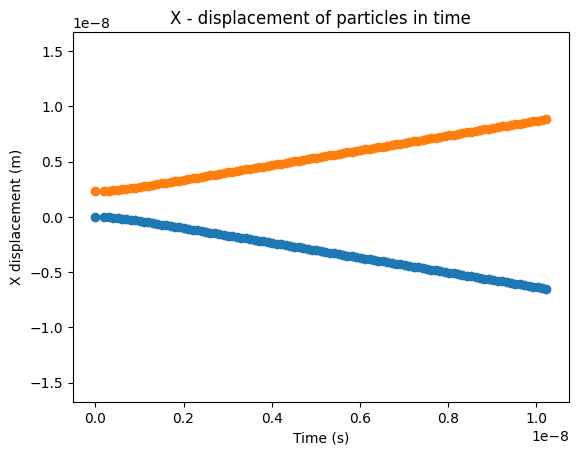

In [7]:
fig,ax = plt.subplots()
ylim = [-50*sigma,50*sigma]
ax.set_ylim(ylim)
ax.set_title('X - displacement of particles in time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('X displacement (m)')
ax.scatter(sim1.times,xCoords[0])
ax.scatter(sim1.times,xCoords[1])


Task 2 Particles in a box

In [8]:
sigma = 0.3345*10**-9 #m
#Simulation box length
length = 20*sigma
#Setting intiial configuration of particles 
initial_x = [0,3*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]
#Construct the simulation object
sim2 = Simulation(length= length,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
#Run the simulation
sim2.main(delt=0.01*sigma,nSteps=1000)

#Extract data for visualisation
xCoords = sim2.particles_x
xCoords = np.transpose(xCoords)
yCoords = sim2.particles_y
yCoords = np.transpose(yCoords)
zCoords = sim2.particles_z
zCoords = np.transpose(zCoords)

xVelCoords = sim2.particles_v_x
xVelCoords = np.transpose(xVelCoords)
xAccCoords = sim2.particles_a_x
xVelCoords = np.transpose(xVelCoords)

times = sim2.times


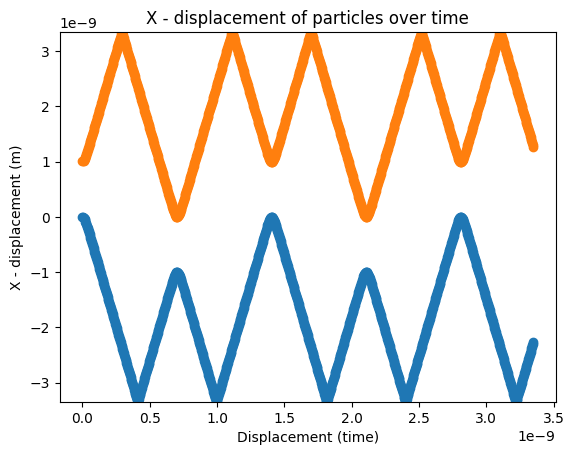

In [9]:
fig,ax=plt.subplots()
ylim = [-length/2,length/2]
ax.set_ylim(ylim)
ax.set_title('X - displacement of particles over time')
ax.set_ylabel('X - displacement (m)')
ax.set_xlabel('Displacement (time)')
xTranspose = np.transpose(sim2.particles_x)
ax.scatter(sim2.times,xTranspose[0])
ax.scatter(sim2.times,xTranspose[1])


Task 3 - Investigate
Before proceeding it will be best to visualize & animate the simulation

In [21]:
sigma = 0.3345*10**-9 #m
#Simulation length
length = 20*sigma
#Initial conditions
initial_x = [-2*sigma,2*sigma]
initial_y = [0.0,0.0]
initial_z = [0.0,0.0]
#Create simulation
sim2 = Simulation(length=length,initial_particle_x=initial_x,initial_particle_y=initial_y,initial_particle_z=initial_z)
sim2.main(delt=0.03*sigma,nSteps=1000)
#Extracting data
xCoords = sim2.particles_x
yCoords = sim2.particles_y
zCoords = sim2.particles_z


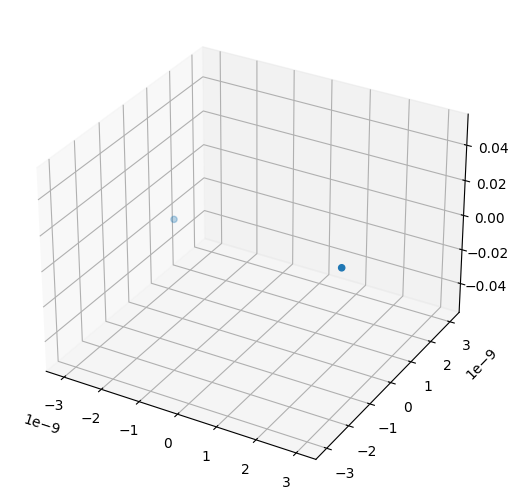

In [22]:
fig = plt.figure()
#Set render boundaries
xlim = [-length/2,length/2]
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(xlim)


#This is the animation function which is called on each update 
def update_points(num):
    #Only render every 10th frame to save time
    num = 10*num
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords[num],yCoords[num],zCoords[num])

#Set the initial frame
graph = ax.scatter(xs=xCoords[0],ys=yCoords[0],zs=zCoords[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,len(xCoords)),repeat=False)
#Note that if you cannot reproduce the gif files for whatever reason,
#You can see them in the gif_archive folder.
anim.save('collison_demonstration.gif')


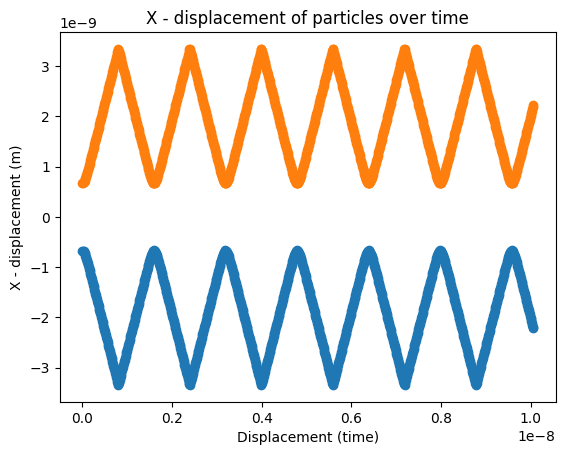

In [14]:
fig,ax = plt.subplots()
ax.set_title('X - displacement of particles over time')
ax.set_ylabel('X - displacement (m)')
ax.set_xlabel('Displacement (time)')
xTranspose = np.transpose(sim2.particles_x)
ax.scatter(sim2.times,xTranspose[0])
ax.scatter(sim2.times,xTranspose[1])

In [18]:
#Set simulation parameters
box_length = 5*sigma
number_particles = 10
#Empty array
sim3_initial_x = []
sim3_initial_y = []
sim3_initial_z = []
#Place 10 particles randomly
for i in range(0,number_particles):
            sim3_initial_x.append(np.random.uniform(-box_length/2,box_length/2))
            sim3_initial_y.append(np.random.uniform(-box_length/2,box_length/2))
            sim3_initial_z.append(np.random.uniform(-box_length/2,box_length/2))




In [19]:
sim3 = Simulation(length=box_length,initial_particle_x=sim3_initial_x,initial_particle_y=sim3_initial_y,initial_particle_z=sim3_initial_z)
sim3.main(delt=0.005*sigma,nSteps=200)
xCoords3 = sim3.particles_x
yCoords3 = sim3.particles_y
zCoords3 = sim3.particles_z
xVelCoords3 = sim3.particles_v_x
yVelCoords3 = sim3.particles_v_y
zVelCoords3 = sim3.particles_v_z
xAccCoords3 = sim3.particles_a_x
yAccCoords3 = sim3.particles_a_y
zAccCoords3 = sim3.particles_a_z
avg_pressure = sim3.calculate_average_pressure(delt=0.01*sigma)
avg_temperature = sim3.calculate_average_temperature()




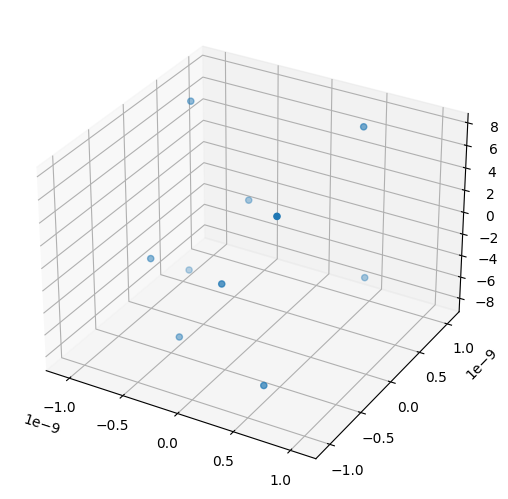

In [20]:
fig = plt.figure()
#Set render boundaries
xlim = [-box_length/2-1*sigma,box_length/2+1*sigma]
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(xlim)

#Function to update frame
def update_points(num):
    num = num
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords3[num],yCoords3[num],zCoords3[num])

graph = ax.scatter(xs=xCoords3[0],ys=yCoords3[0],zs=zCoords3[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,50),repeat=False)
anim.save('10_particle.gif')


Now I will set the number of particles to 100 and begin gathering some data

I tried to automate data gathering, but I could not debug an issue with resetting the random seed generator within a nested loop within a function, so I have had to combine automation with manual data entry unfortunately.

There is an accomanying notebook which contains graphs for analysis and all the relevant simulation data

Below is the code I used to gather data

In [191]:
#Initialize temperature,pressure arrays
temperatures = []
pressures = []

In [193]:
#Simulation parameters
#box_length parameter was used as an independent variable for data gathering 
box_length = 50*sigma
number_particles = 100
del_time = 0.01*sigma
sim4_initial_x = []
sim4_initial_y = []
sim4_initial_z = []

#This makes the pool of random possibilities larger for higher number particle simulations
n_loop = 3*number_particles+3
max_rand_int = 1000*n_loop
seeds = np.random.randint(max_rand_int,size = n_loop)
#Randomly generate the initial conditions
for i in range(0,number_particles):
            sim4_initial_x.append(np.random.uniform(-box_length/2,box_length/2))
            sim4_initial_y.append(np.random.uniform(-box_length/2,box_length/2))
            sim4_initial_z.append(np.random.uniform(-box_length/2,box_length/2))
            seed = seeds[i]
            np.random.seed(seed)
#Create the simulation object
sim4 = Simulation(length=box_length,initial_particle_x=sim4_initial_x,initial_particle_y=sim4_initial_y,initial_particle_z=sim4_initial_z)
#Run the simulation
sim4.main(delt=del_time,nSteps=100)
xCoords4 = sim4.particles_x

yCoords4 = sim4.particles_y

zCoords4 = sim4.particles_z


xVelCoords4 = sim4.particles_v_x
yVelCoords4 = sim4.particles_v_y
zVelCoords4 = sim4.particles_v_z

xAccCoords4 = sim4.particles_a_x
yAccCoords4 = sim4.particles_a_y
zAccCoords4 = sim4.particles_a_z
avg_pressure_4 = sim4.calculate_average_pressure(delt=del_time)
avg_temperature_4 = sim4.calculate_average_temperature()
temperatures.append(avg_temperature_4)
pressures.append(avg_pressure_4)
[temperatures,pressures]





[[1.2366489779246665, 0.16432366564661646],
 [761.8096208485608, 136.80987216970414]]

Investigation 2 investigating the relationship between initial particle density and average temperature

In [274]:
temperatures = []
pressures = []

In [23]:
# sim4 = Simulation(length=box_length,initial_particle_x=sim3_initial_x,initial_particle_y=sim3_initial_y,initial_particle_z=sim3_initial_z)

box_length = 10*sigma
#number_particles_4 was the varied parameter
number_particles_4 = 500
del_time = 0.02*sigma
sim4_initial_x = []
sim4_initial_y = []
sim4_initial_z = []

n_loop = 3*number_particles_4+3
max_rand_int = 1000*n_loop
seeds = np.random.randint(max_rand_int,size = n_loop)

for i in range(0,number_particles_4):
            sim4_initial_x.append(np.random.uniform(-box_length/2,box_length/2))
            sim4_initial_y.append(np.random.uniform(-box_length/2,box_length/2))
            sim4_initial_z.append(np.random.uniform(-box_length/2,box_length/2))
            seed = seeds[i]
            np.random.seed(seed)
sim4 = Simulation(length=box_length,initial_particle_x=sim4_initial_x,initial_particle_y=sim4_initial_y,initial_particle_z=sim4_initial_z)
sim4.main(delt=del_time,nSteps=200)
xCoords4 = sim4.particles_x
# xCoords3 = np.transpose(xCoords)
yCoords4 = sim4.particles_y
# yCoords3 = np.transpose(yCoords)
zCoords4 = sim4.particles_z
# zCoords3 = np.transpose(zCoords)

xVelCoords4 = sim4.particles_v_x
yVelCoords4 = sim4.particles_v_y
zVelCoords4 = sim4.particles_v_z
# xVelCoor4s3 = n4.transpose(xVelCoords)
xAccCoords4 = sim4.particles_a_x
yAccCoords4 = sim4.particles_a_y
zAccCoords4 = sim4.particles_a_z
avg_pressure_4 = sim4.calculate_average_pressure(delt=del_time)
avg_temperature_4 = sim4.calculate_average_temperature()
temperatures.append(avg_temperature_4)
pressures.append(avg_pressure_4)
[temperatures,pressures]



NameError: name 'temperatures' is not defined

In [ ]:
n_particles_arr = [5,5,5,10,50,100,500,1000]

0.10917106189781053

KeyboardInterrupt: 

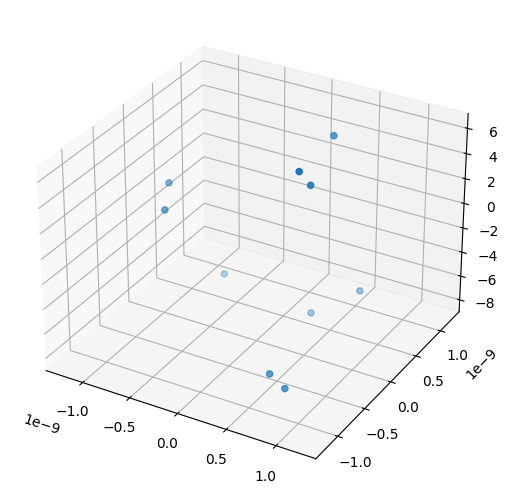

In [ ]:
fig = plt.figure()
xlim = [-box_length/2-1*sigma,box_length/2+1*sigma]
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)    
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim)
ax.set_ylim(xlim)
# ax.set_zlim(xlim)

def update_points(num):
    num = num
    if (num <= len(xCoords)):
        graph._offsets3d = (xCoords4[num],yCoords4[num],zCoords4[num])
# index = 3
# ax.scatter(xs=xCoords[index],ys=yCoords[index],zs=zCoords[index])
    # return fig,ax
graph = ax.scatter(xs=xCoords4[0],ys=yCoords4[0],zs=zCoords4[0])
anim = FuncAnimation(fig,update_points,frames=np.arange(0,50),repeat=False)
anim.save('100_particle_simulation.gif')


In [ ]:
sim5_temperatures = []
sim5_pressures = []

In [ ]:

np.random.randint(0,5)

0

In [ ]:
import time 
import random
box_length = 6*sigma
number_particles_4 = 100
sim5_initial_x = []
sim5_initial_y = []
sim5_initial_z = []

random_array = np.random.default_rng().uniform(-box_length/2,box_length/2,5*300)

# for k in range(1,6):
for i in range(1,number_particles_4+1):
            sim5_initial_x.append(random_array[i])
            sim5_initial_y.append(random_array[i*2])
            sim5_initial_z.append(random_array[i*3])
sim5 = Simulation(length=box_length,initial_particle_x=sim3_initial_x,initial_particle_y=sim3_initial_y,initial_particle_z=sim3_initial_z)
sim5.main(delt=0.002*sigma,nSteps=100)
sim5_temperatures.append(copy.copy(sim5.calculate_average_temperature()))
sim5_pressures.append(copy.copy(sim5.calculate_average_pressure(delt=0.002*sigma)))

In [ ]:
sim5_pressures

[112409.29010431882,
 112409.29010431882,
 112409.29010431882,
 112409.29010431882]